In [2]:
import tensorflow as tf 
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing import image
import tensorflow.keras.callbacks
import cv2
from PIL import Image
import numpy as np
import pandas as pd

import boto3

In [3]:
word_level_train = pd.read_csv('../../data/preprocessed/word_level_train.csv')
word_level_test = pd.read_csv('../../data/preprocessed/word_level_test.csv')
data_path = '../../data/raw/word_level'

In [4]:
# import tensorflow as tf
# sess = tf.Session()
# K.set_session(sess)

In [5]:
letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [6]:
# sort by token length
word_level_train['token_len'] = word_level_train.token.apply(len)
word_level_train.sort_values('token_len', inplace=True)
word_level_train = word_level_train[word_level_train['token_len'] == 5]

word_level_test['token_len'] = word_level_test.token.apply(len)
word_level_test.sort_values('token_len', inplace=True)
word_level_test = word_level_test[word_level_test['token_len'] == 5]

In [7]:
from collections import defaultdict, Counter
import dill as pickle


def labels_to_text(labels, letters):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text, letters):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s, letters):
    for ch in s:
        if not ch in letters:
            return False
    return True

def unpickle(filename):
    """Unpickle file"""
    with open(filename, 'rb') as f:
        return pickle.load(f)

class TextImageGenerator:
    
    def __init__(self, word_level_df, data_path, img_width, img_height, batch_size, downsample_factor, 
                 max_text_len=21+1, pre_pad=True, use_s3=False, letters=None):
        
#         self.letters = letters
#         # create letters mapping 
#         # +2 0 for pad value and 1 for OOV
#         self.letter2idx = defaultdict(lambda: 1, {x: i+2 for i, x in enumerate(sorted(letters))})
#         self.letter2idx['<unk>'] = 1
#         self.letter2idx['<pad>'] = 0
#         self.pad_idx = self.letter2idx['<pad>']
#         self.idx2letter = {v: k for k, v in self.letter2idx.items()}
        
#         if save_letters:
#             with open(os.path.join('../../data/', 'processed', 'letters_map.pkl'), 'wb') as f:
#                 pickle.dump(self.letter2idx, f, protocol=2)
        
        self.data_path = data_path
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.downsample_factor = downsample_factor
        self.max_text_len = max_text_len
        self.pre_pad = pre_pad
        
        # TODO: should I create DF as well? 
        self.word_level_df = word_level_df
#         self.word_level_df = create_word_level_df(meta)
#         self.word_level_df = create_image_path(self.word_level_df, data_path)
        if letters == None:
            self.letters = sorted(list(Counter(''.join(word_level_df.token.values)).keys()))
            self.letters.append(' ')
            self.letters = sorted(list(set(self.letters)))
        else:
            self.letters = letters
        self.pad_idx = self.letters.index(' ')
#         self.pad_idx = self.letters[0] # corresponds to ' '
        
        # training data 
        self.samples = self.word_level_df[['image_path', 'token']].values.tolist()
        self.N = len(self.samples)
        self.current_index = 0
        
    def build_data(self):
        self.images = np.zeros((self.N, self.img_height, self.img_width))
        self.texts = []
        bad_records = []
        for i, (img_path, text) in enumerate(self.samples):
            try:
                # read image 
                img = cv2.imread(img_path)
                # grayscale image
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # resize image
                img = cv2.resize(img, (self.img_width, self.img_height))
                # change image type
                img = img.astype(np.float32)
                # scale image 
                img /= 255
                # width and height are backwards from typical Keras convention
                # because width is the time dimension when it gets fed into the RNN
                self.images[i, :, :] = img
                self.texts.append(text)
            except:
                print('Image not available for image', i, img_path, text)
                bad_records.append(i)
        # update stats to remove bad records with no image data 
        self.N -= len(bad_records)
        self.indexes = list(range(self.N))
        self.images = np.delete(self.images, bad_records, axis=0)

    def get_output_size(self):
        return len(self.letters) + 1
#         return len(all_letters) + 1

    def next_sample(self):
        self.current_index += 1
        if self.current_index >= self.N:
            self.current_index = 0
            random.shuffle(self.indexes)
        return self.images[self.indexes[self.current_index]], self.texts[self.indexes[self.current_index]]

    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X = np.ones([self.batch_size, 1, self.img_width, self.img_height])
            else:
                X = np.ones([self.batch_size, self.img_width, self.img_height, 1])

            y = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_width // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []

            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X[i] = img
#                 pdb.set_trace()
#                 y_numeric = text_to_labels(text, self.letters)
                y_numeric = text_to_labels(text, self.letters)
#                 print(y_numeric)
#                 y_numeric = [self.letter2idx[l] for l in text]
                if self.pre_pad: padded_y = ([self.pad_idx] * (self.max_text_len - len(y_numeric))) + y_numeric
                else: padded_y = y_numeric + ([self.pad_idx] * (self.max_text_len - len(y_numeric)))
#                 print(padded_y)
                y[i] = padded_y
#                 y[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)

            inputs = {
                'the_input': X,
                'the_labels': y,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }          
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

        

In [8]:
# CTC_SKIP_FIRST = 2
# image_width = 128 
# image_height = 64
# conv_filters = 16
# kernel_size = (3, 3)
# pool_size = 2
# time_dense_size = 32
# rnn_size = 512
# batch_size = 32
# downsample_factor = pool_size ** 2
# max_text_len = 21
# activation = 'relu'
# learning_rate = 0.02
# epochs = 1



# sample_train = word_level_train.sample(1000)

# train_tiger = TextImageGenerator(sample_train, data_path, image_width, image_height, batch_size, 
#                                downsample_factor, max_text_len, pre_pad=False, letters=None)
# train_tiger.build_data()

In [9]:
# for i in train_tiger.next_batch():
#     print(i)
#     break

In [11]:
CTC_SKIP_FIRST = 2
image_width = 128 
image_height = 64
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
batch_size = 32
downsample_factor = pool_size ** 2
max_text_len = 5 #21
activation = 'relu'
learning_rate = 0.02
epochs = 1



from tensorflow.keras.layers import Bidirectional, GRU

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def get_model(word_level_train, word_level_test, img_w, letters=None, sample_size=None):
    
    img_h = 64

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        
    batch_size = 32
    downsample_factor = pool_size ** 2
#     downsample_factor = 2
#     letters_concat = ''.join(letters)
    if sample_size:
        word_level_train = word_level_train.sample(sample_size)
    train_tiger = TextImageGenerator(word_level_train, data_path, image_width, image_height, batch_size, 
                               downsample_factor, max_text_len, pre_pad=False, letters=letters)
    train_tiger.build_data()
    
#     if sample_size:
#         word_level_test = word_level_test.sample(sample_size)
    test_tiger = TextImageGenerator(word_level_test, data_path, image_width, image_height, batch_size, 
                               downsample_factor, max_text_len, pre_pad=False, letters=letters) # update letters 
    test_tiger.build_data()
    
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)
#     print(inner.shape)
    
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)
#     print(inner.shape)
    
    gru1 = Bidirectional(GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1'))(inner)
    gru2 = Bidirectional(GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1'))(gru1)
    inner = Dense(train_tiger.get_output_size(), kernel_initializer='he_normal', name='dense2')(gru2)
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()
    
    labels = Input(name='the_labels', shape=[train_tiger.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    
    sgd = SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#     optimizer = Adam(lr=0.05)

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
#     print(model.summary())
    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_data], [y_pred])

    model.fit_generator(generator=train_tiger.next_batch(), 
                        steps_per_epoch=train_tiger.N,
                        validation_data=test_tiger.next_batch(), 
                        validation_steps=test_tiger.N,
                        epochs=epochs)

    return model

In [12]:
len(word_level_train)

8986

In [13]:
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

model = get_model(word_level_train, word_level_test, 128, letters=letters, sample_size=None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 128, 64, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 64, 16)       160       
_________________________________________________________________
max1 (MaxPooling2D)          (None, 64, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 32, 16)        2320      
_________________________________________________________________
max2 (MaxPooling2D)          (None, 32, 16, 16)        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 256)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 32)            8224      
__________

In [43]:
# len 5 0.3 -- 3000/3000 [==============================] - 363s 121ms/step - loss: 10.3520 - val_loss: 15.3139
# len 5 0.3 -- 8986/8986 [==============================] - 921s 102ms/step - loss: 7.2772 - val_loss: 9.9019

In [17]:
model.save('models/ocr_5_len.h5')

Predicted: sisce
True: issue


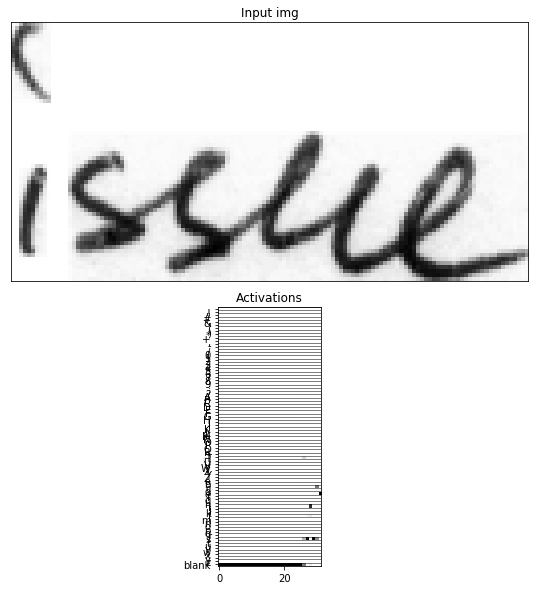

Predicted: would
True: would


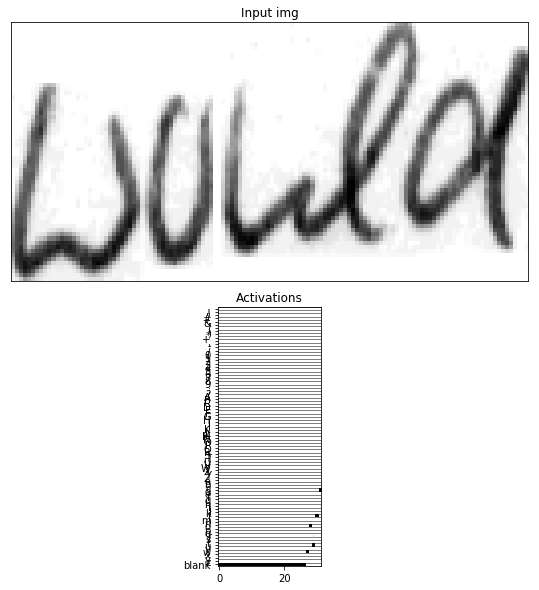

Predicted: being
True: being


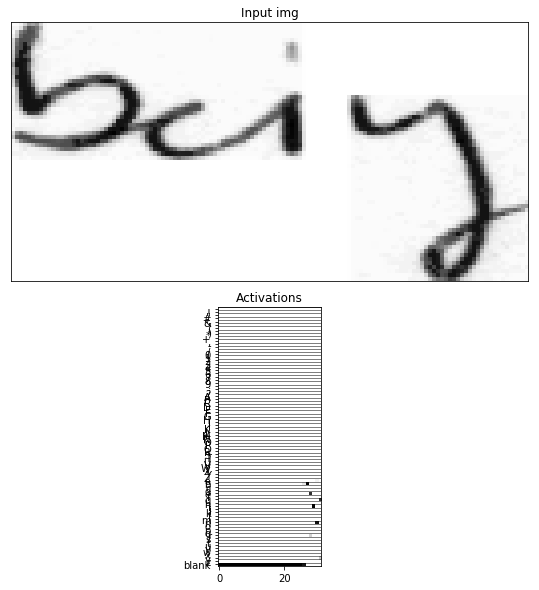

Predicted: scons
True: seems


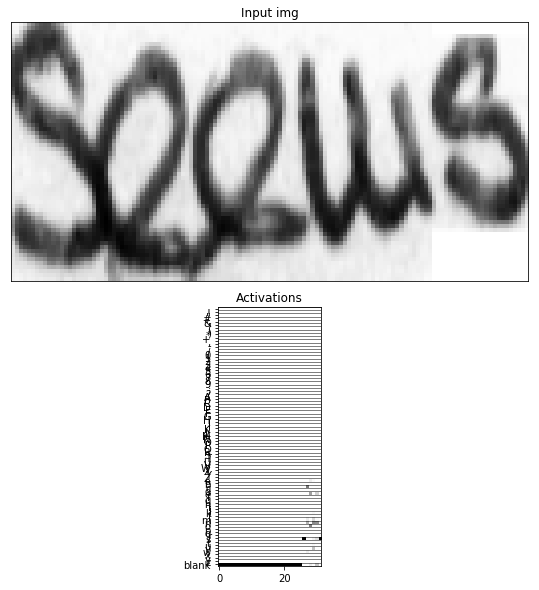

Predicted: could
True: could


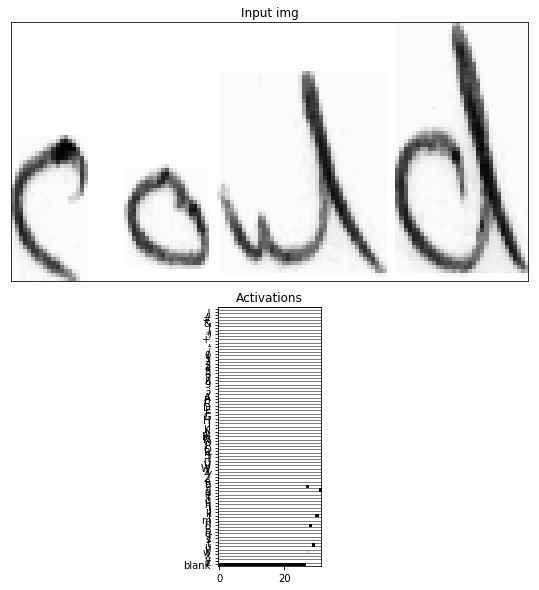

Predicted: going
True: going


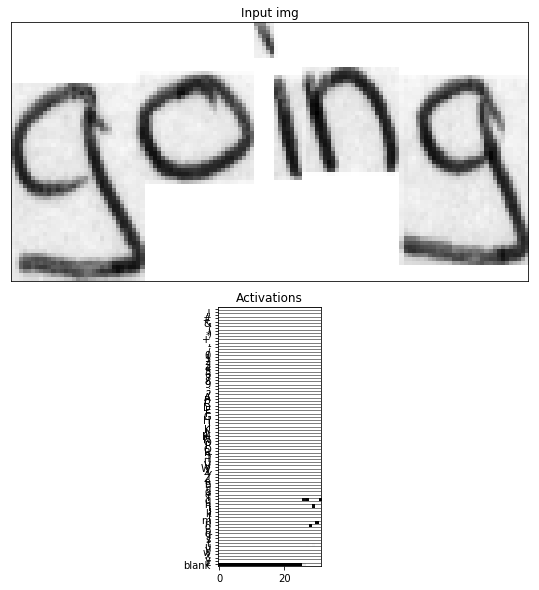

Predicted: lais
True: hours


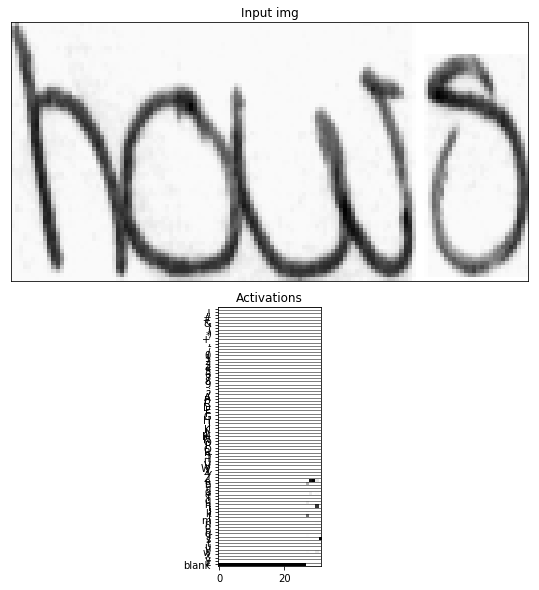

Predicted: place
True: place


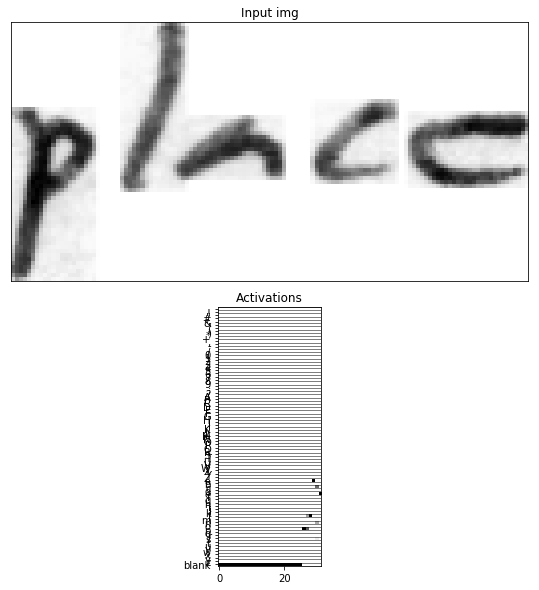

Predicted: lins
True: lines


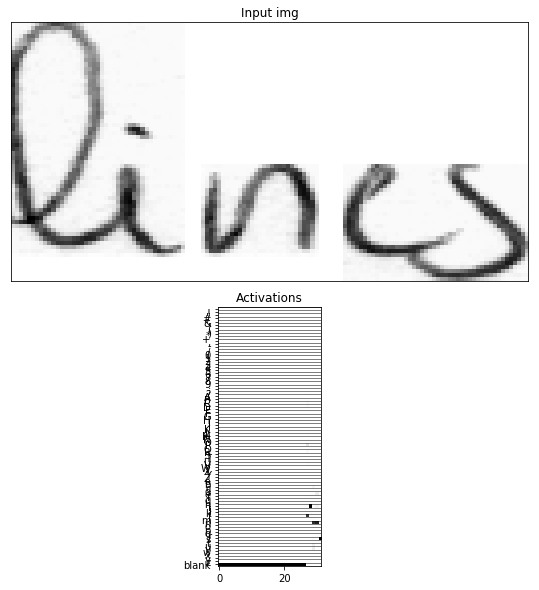

Predicted: which
True: which


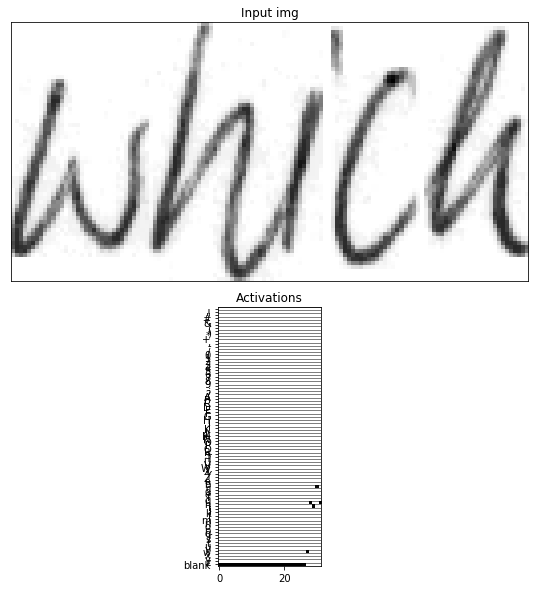

Predicted: smuge
True: range


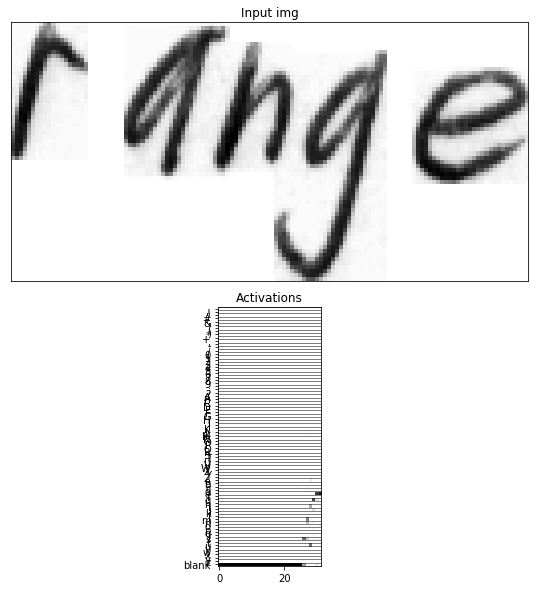

Predicted: ther
True: these


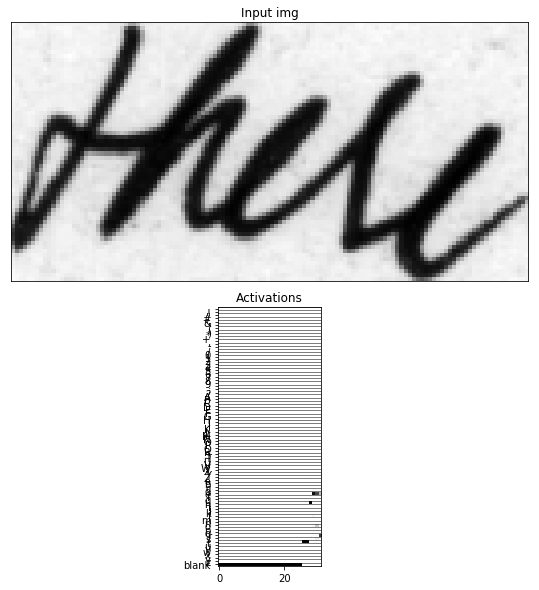

Predicted: Fanny
True: Fanny


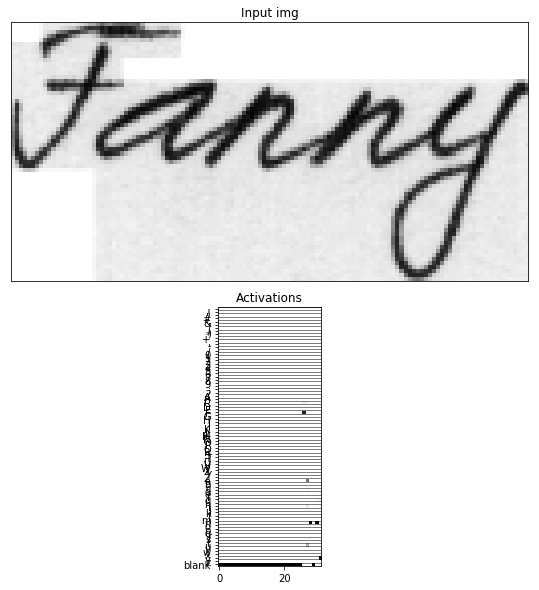

Predicted: firat
True: first


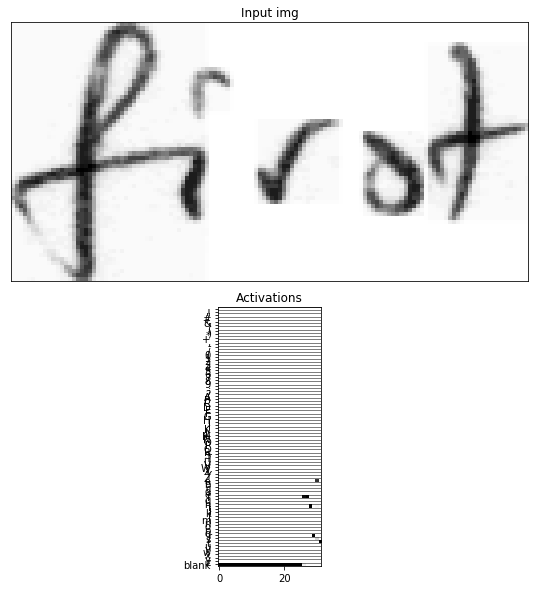

Predicted: syears
True: yours


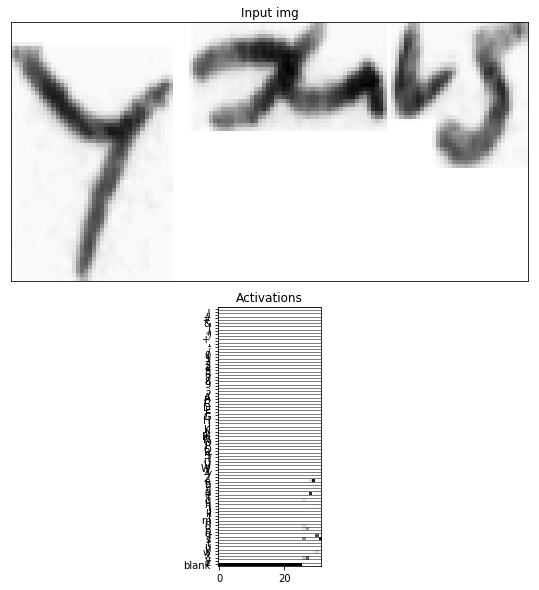

Predicted: afker
True: after


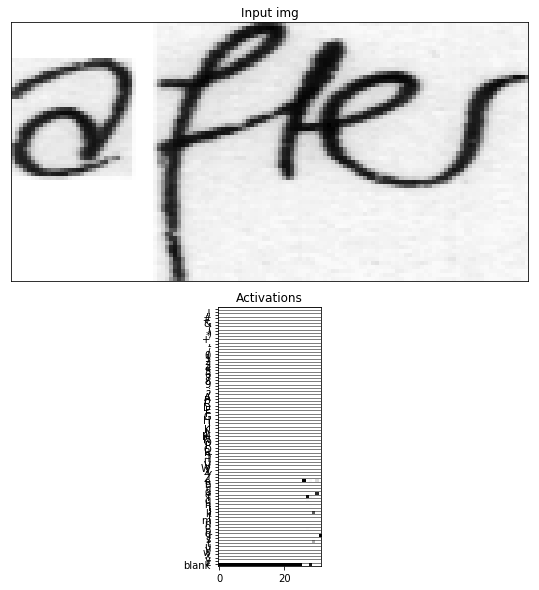

Predicted: great
True: grant


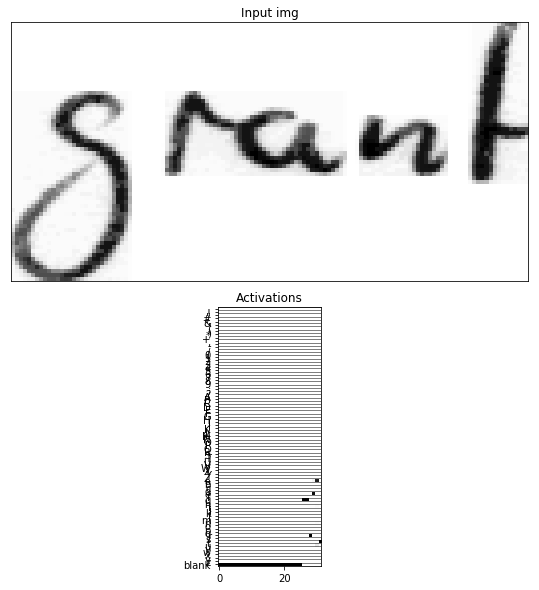

Predicted: fornt
True: firms


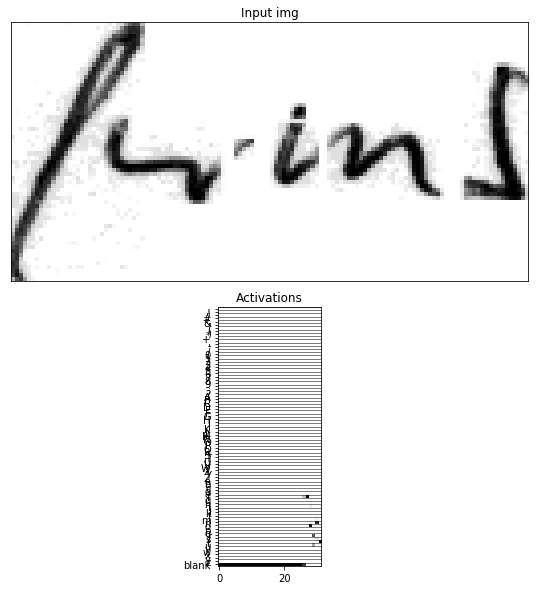

Predicted: HRe
True: AFTER


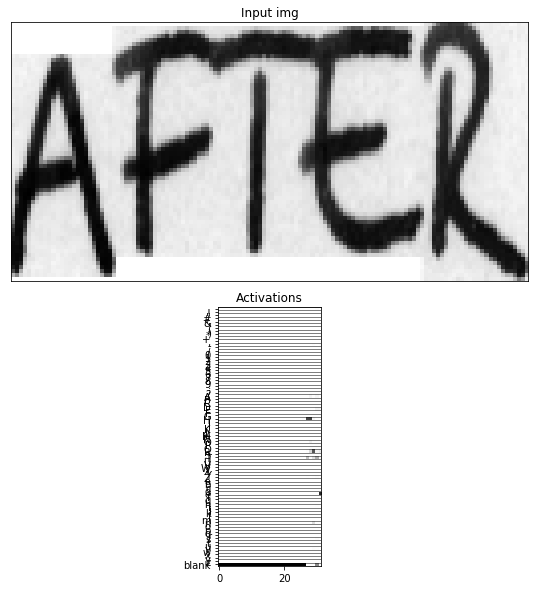

Predicted: dlane
True: dance


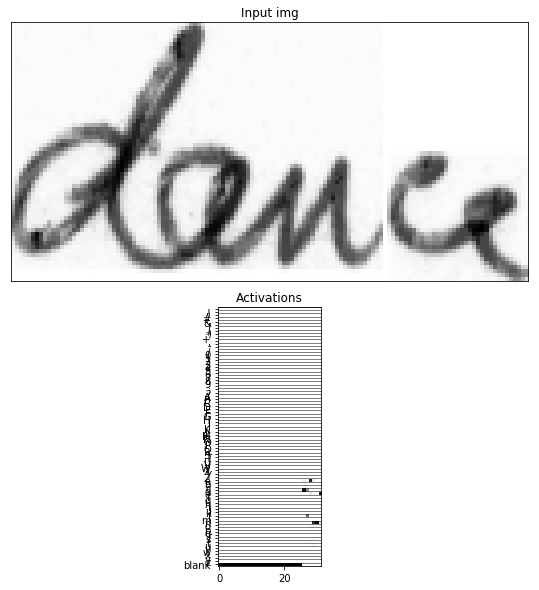

Predicted: levar
True: their


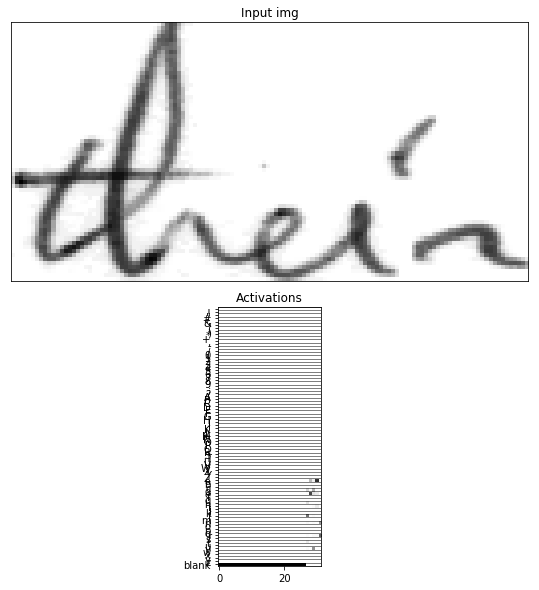

Predicted: heant
True: heard


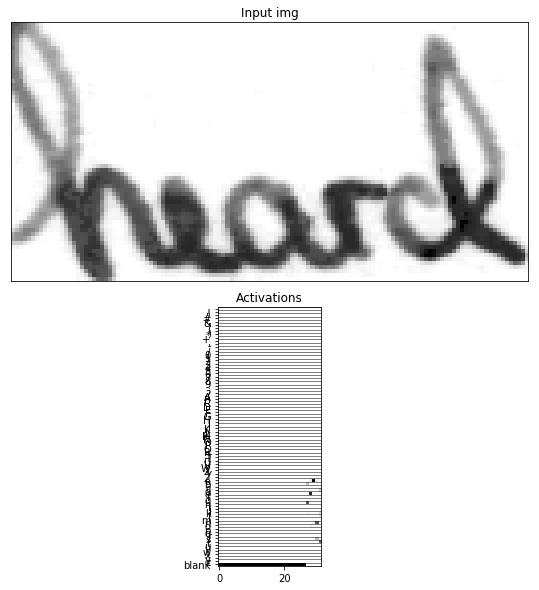

Predicted: basis
True: basis


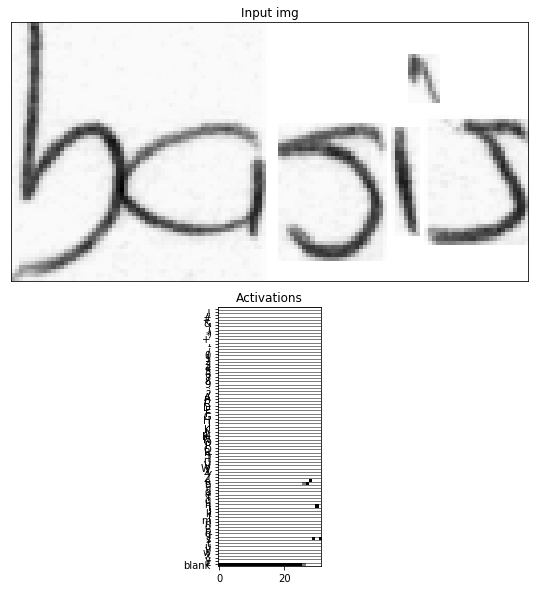

Predicted: pirce
True: Space


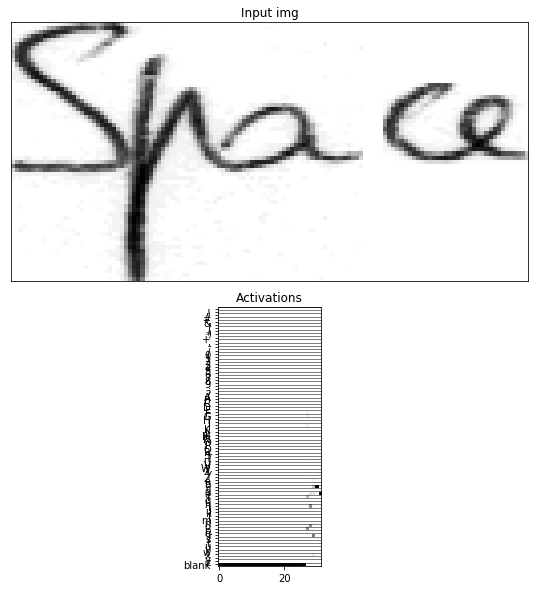

Predicted: ofter
True: other


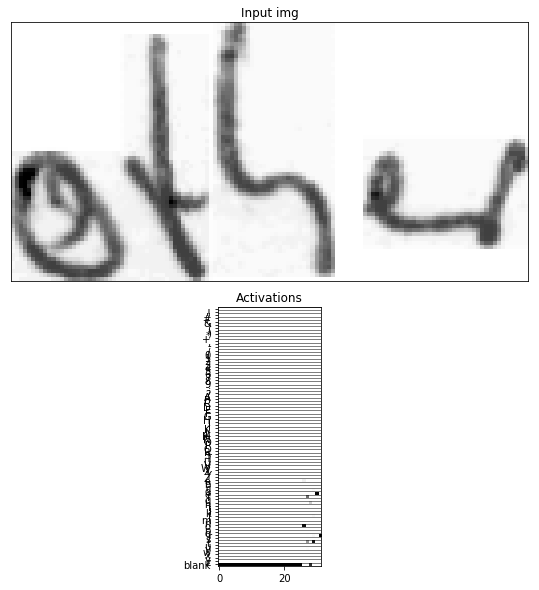

Predicted: point
True: point


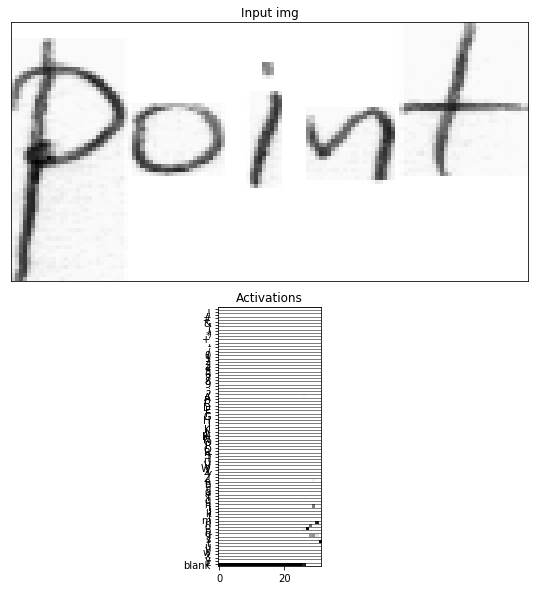

Predicted: bege
True: begin


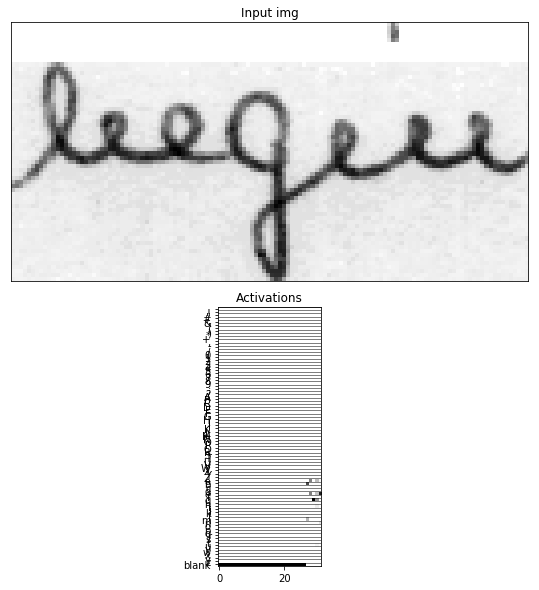

Predicted: clear
True: these


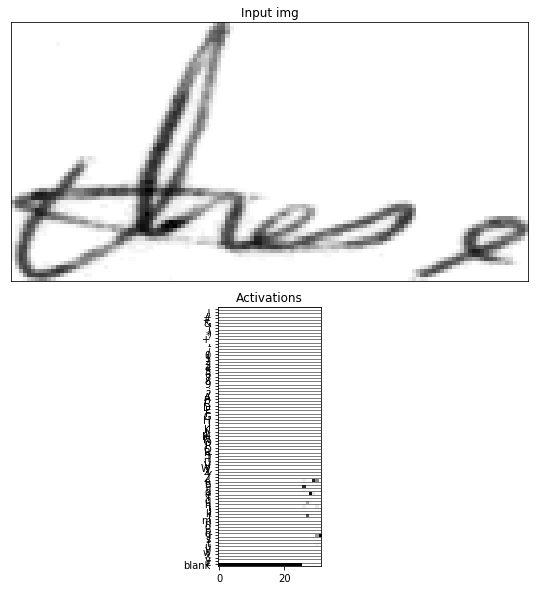

Predicted: toms
True: knows


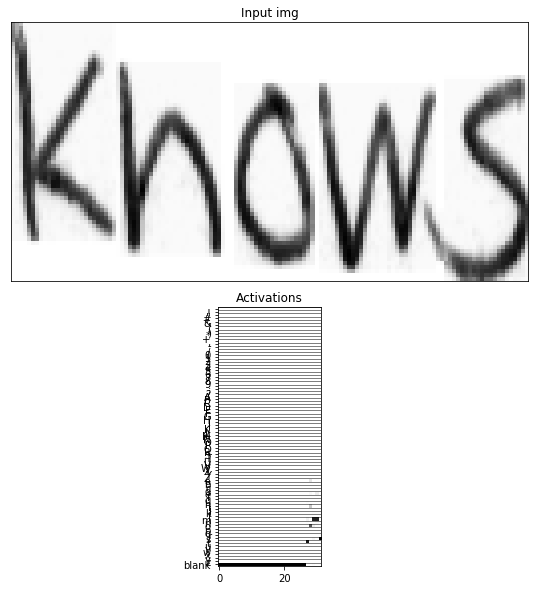

Predicted: troin
True: train


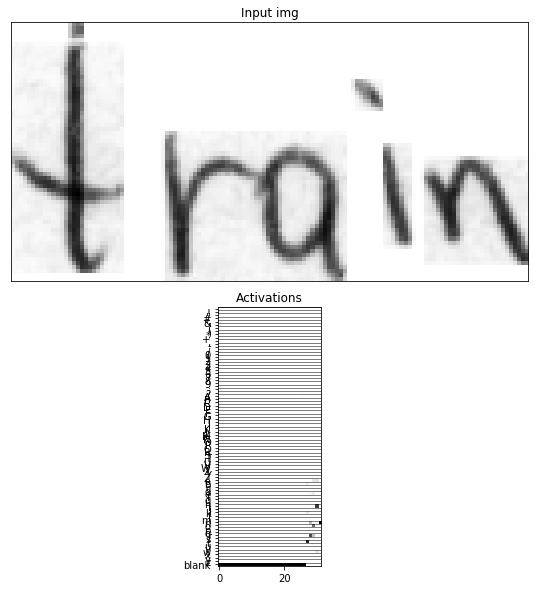

Predicted: fiet
True: tried


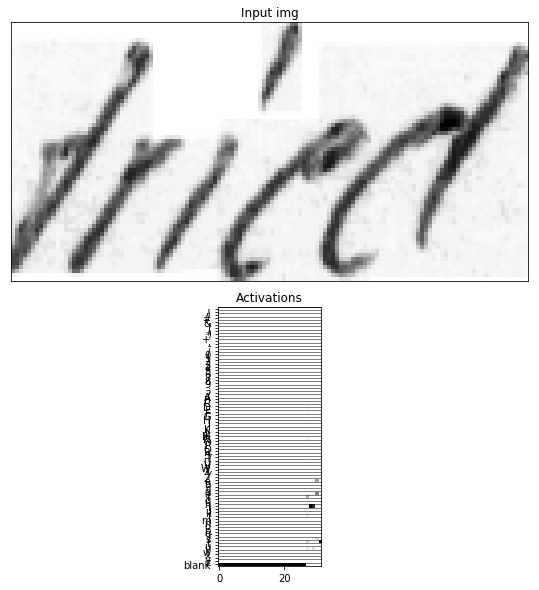

Predicted: April
True: April


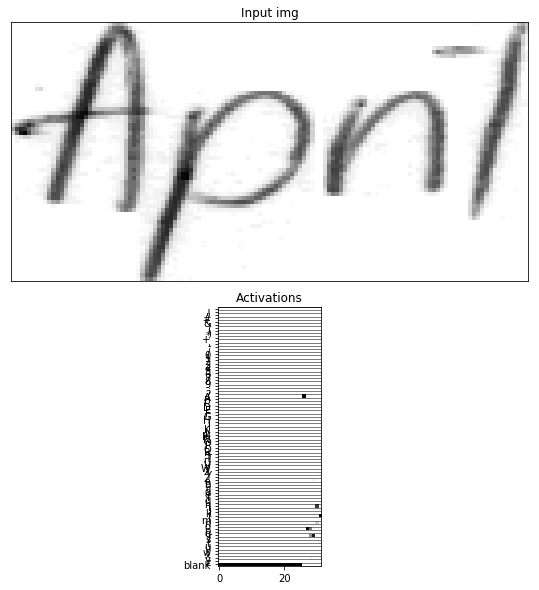

In [14]:
test_tiger = TextImageGenerator(word_level_test, data_path, image_width, image_height, batch_size, 
                               downsample_factor, max_text_len, pre_pad=False, letters=letters) # update letters 
    
test_tiger.build_data()

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

for inp_value, _ in test_tiger.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break

In [ ]:
for inp_value, _ in tiger_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break

In [36]:
from collections import Counter

Counter(''.join(word_level_train.token.values)).keys()

letters = sorted(list(Counter(''.join(word_level_train.token.values)).keys()))

In [ ]:
max_text_len = 21 

padded_y = ([pad_idx] * (max_text_len - len(y_numeric))) + y_numeric

In [40]:
letters[0]

' '

In [21]:
word_level_train.image_path.iloc[0]

'../../data/raw/word_level/c03/c03-096f/c03-096f-03-05.png'

# Evaluation testing 

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import itertools
# from models.ocr.src.config import letters

letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


/home/matt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
!ls ../app/models/ocr/models/ocr_2_10_lr_01_size_128.h5

ocr_2_10.h5		    ocr_model_best_6.98.hdf5
ocr_2_10_lr_01_size_128.h5  weights-improvement2-10-01-12.22.hdf5
ocr_2_10_lr_01_size_256.h5  weights-improvement2-10-01-3.00.hdf5
ocr_5_len.h5		    weights-improvement2-10-01-4.09.hdf5


In [2]:
sess = tf.Session()
K.set_session(sess)

model_path = '../app/models/ocr/models/ocr_2_10_lr_01_size_128.h5'
model = load_model(model_path, custom_objects={'<lambda>': lambda y_true, y_pred: y_pred})

In [5]:
from collections import defaultdict, Counter
import dill as pickle
import cv2
import os
import numpy as np
from scipy import ndimage
import random
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K


def labels_to_text(labels, letters):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text, letters):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s, letters):
    for ch in s:
        if not ch in letters:
            return False
    return True

def unpickle(filename):
    """Unpickle file"""
    with open(filename, 'rb') as f:
        return pickle.load(f)

class TextImageGenerator:
    
    def __init__(self, word_level_df, data_path, img_width, img_height, batch_size, downsample_factor,
                 max_text_len=21, samples=None, pre_pad=True, use_s3=False, letters=None, is_training=True):
        
        self.data_path = data_path
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.downsample_factor = downsample_factor
        self.max_text_len = max_text_len
        self.pre_pad = pre_pad
        self.is_training = is_training
        self.use_s3 = use_s3
        
        word_level_df['image_path'] = word_level_df['image_path'].map(lambda x: 
                                                    self.data_path + x.split('word_level')[-1])
        self.word_level_df = word_level_df

        if letters == None:
            self.letters = sorted(list(Counter(''.join(word_level_df.token.values)).keys()))
            self.letters.append(' ')
            self.letters = sorted(list(set(self.letters)))
        else:
            self.letters = letters
        self.pad_idx = self.letters.index(' ')
        
        # training data 
        if samples:
            self.samples = samples
        else: 
            self.samples = self.word_level_df[['image_path', 'token']].values.tolist()
        self.N = len(self.samples)
        self.current_index = 0
        
    def build_data(self):
        self.images = np.zeros((self.N, self.img_height, self.img_width))
        self.texts = []
        bad_records = []
        for i, (img_path, text) in enumerate(self.samples):
            try:
                # read image 
                if self.use_s3:
                    if '.png' in img_path.key:
                        img = img_path.get()['Body'].read()  
                        img = np.frombuffer(img, np.uint8)
                        img = cv2.imdecode(img, 1)
                else:
                    img = cv2.imread(img_path)
                # grayscale image
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # resize image
                img = cv2.resize(img, (self.img_width, self.img_height))
                # change image type
                img = img.astype(np.float32)
                # scale image 
                img /= 255
                # width and height are backwards from typical Keras convention
                # because width is the time dimension when it gets fed into the RNN
                self.images[i, :, :] = img
                self.texts.append(text)
            except:
                print('Image not available for image', i, img_path, text)
                bad_records.append(i)
        # update stats to remove bad records with no image data 
        self.N -= len(bad_records)
        self.indexes = list(range(self.N))
        self.images = np.delete(self.images, bad_records, axis=0)

    def get_output_size(self):
        return len(self.letters) + 1
#         return len(all_letters) + 1

    def next_sample(self):
        self.current_index += 1
        if self.current_index >= self.N:
            self.current_index = 0
            random.shuffle(self.indexes)
        return self.images[self.indexes[self.current_index]], self.texts[self.indexes[self.current_index]]

    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X = np.ones([self.batch_size, 1, self.img_width, self.img_height])
            else:
                X = np.ones([self.batch_size, self.img_width, self.img_height, 1])

            y = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_width // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []

            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X[i] = img
                y_numeric = text_to_labels(text, self.letters)
                if self.pre_pad: padded_y = ([self.pad_idx] * (self.max_text_len - len(y_numeric))) + y_numeric
                else: padded_y = y_numeric + ([self.pad_idx] * (self.max_text_len - len(y_numeric)))
                y[i] = padded_y
                source_str.append(text)
                label_length[i] = len(text)

            inputs = {
                'the_input': X,
                'the_labels': y,
                'input_length': input_length,
                'label_length': label_length,
            }          
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

        

In [ ]:
ls ../../data/preprocessed/word_level_test.csv

In [93]:
USE_S3 = False
img_w = 128 
img_h = 64
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 128
batch_size = 1
downsample_factor = pool_size ** 2
max_text_len = 10
activation = 'relu'
learning_rate = 0.01
epochs = 1
greater_than_val = 5
less_than_val = 10
test_samples = None
import pandas as pd


def subset_data(word_level_df, greater_than_val, less_than_val):
    word_level_df['token_len'] = word_level_df.token.apply(len)
    word_level_df.sort_values('token_len', inplace=True)
    word_level_df = word_level_df[(word_level_df['token_len'] >= greater_than_val) & (word_level_df['token_len'] < less_than_val)]
    return word_level_df


word_level_test = pd.read_csv('../../data/preprocessed/word_level_test.csv')
data_path = '../../data/raw/word_level'

word_level_test = subset_data(word_level_test, greater_than_val, less_than_val)
# shuffle
word_level_test = word_level_test.sample(frac=1)
word_level_test = word_level_test[word_level_test.token == 'musician']
    
test_tiger = TextImageGenerator(word_level_test, data_path, img_w, img_h, batch_size, downsample_factor, 
            max_text_len, pre_pad=False, letters=letters, samples=test_samples, use_s3=USE_S3) 
test_tiger.build_data()

In [64]:
word_level_test.token.values.tolist()

['Freedom',
 'priest',
 'killing',
 'incidence',
 'children',
 'notice',
 'Giuseppe',
 'carried',
 'prayer',
 'Lepanto',
 'Scottish',
 'history',
 'impale',
 'earthly',
 'small',
 'motion',
 'needed',
 'wrote',
 'event',
 'Senator',
 'dusted',
 'sensitive',
 'deeds',
 'Maybe',
 'South',
 'women',
 "Mauro's",
 'coldly',
 'teenagers',
 'receiving',
 'dressed',
 'three',
 'putting',
 'required',
 'lower',
 'sentences',
 'plenty',
 'village',
 'charged',
 'catch',
 'depending',
 'memory',
 'evidence',
 'brought',
 'Lancaster',
 'below',
 'moreover',
 'about',
 'Common',
 'system',
 'cliff',
 'matched',
 'Bueno',
 'could',
 'cannot',
 'there',
 'severity',
 'dress',
 'separate',
 'whoever',
 "doesn't",
 'South',
 'mounting',
 'another',
 'suggested',
 'early',
 'efficient',
 'would',
 'CHILDREN',
 'daily',
 'outside',
 'skilled',
 'should',
 'chest',
 'burden',
 'pushed',
 'fitted',
 'takes',
 'pressed',
 'enjoyment',
 'money',
 'obstacle',
 'circles',
 'Isaiah',
 'collected',
 'basis',
 'o

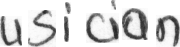

In [68]:
from PIL import Image
Image.open(word_level_test[word_level_test.token == 'musician'].image_path.iloc[0])

['u', 's', 'i', 'c', 'i', 'a', 'n']

[1.         0.99999964 0.937873   0.9952304  1.         1.
 1.         0.99999285 0.9995179  0.9954472  1.         0.99813974
 0.9882108  0.9994591  0.99999917 1.         0.9995065  0.9991755
 0.9999356  0.9905591  0.9896605  0.99999964 1.         1.
 0.99864393 0.9432098  0.9998455  0.9999794  0.99973744 0.96497345]
Predicted: ------u--------s------i--------c--i----------a------n
True: musician  


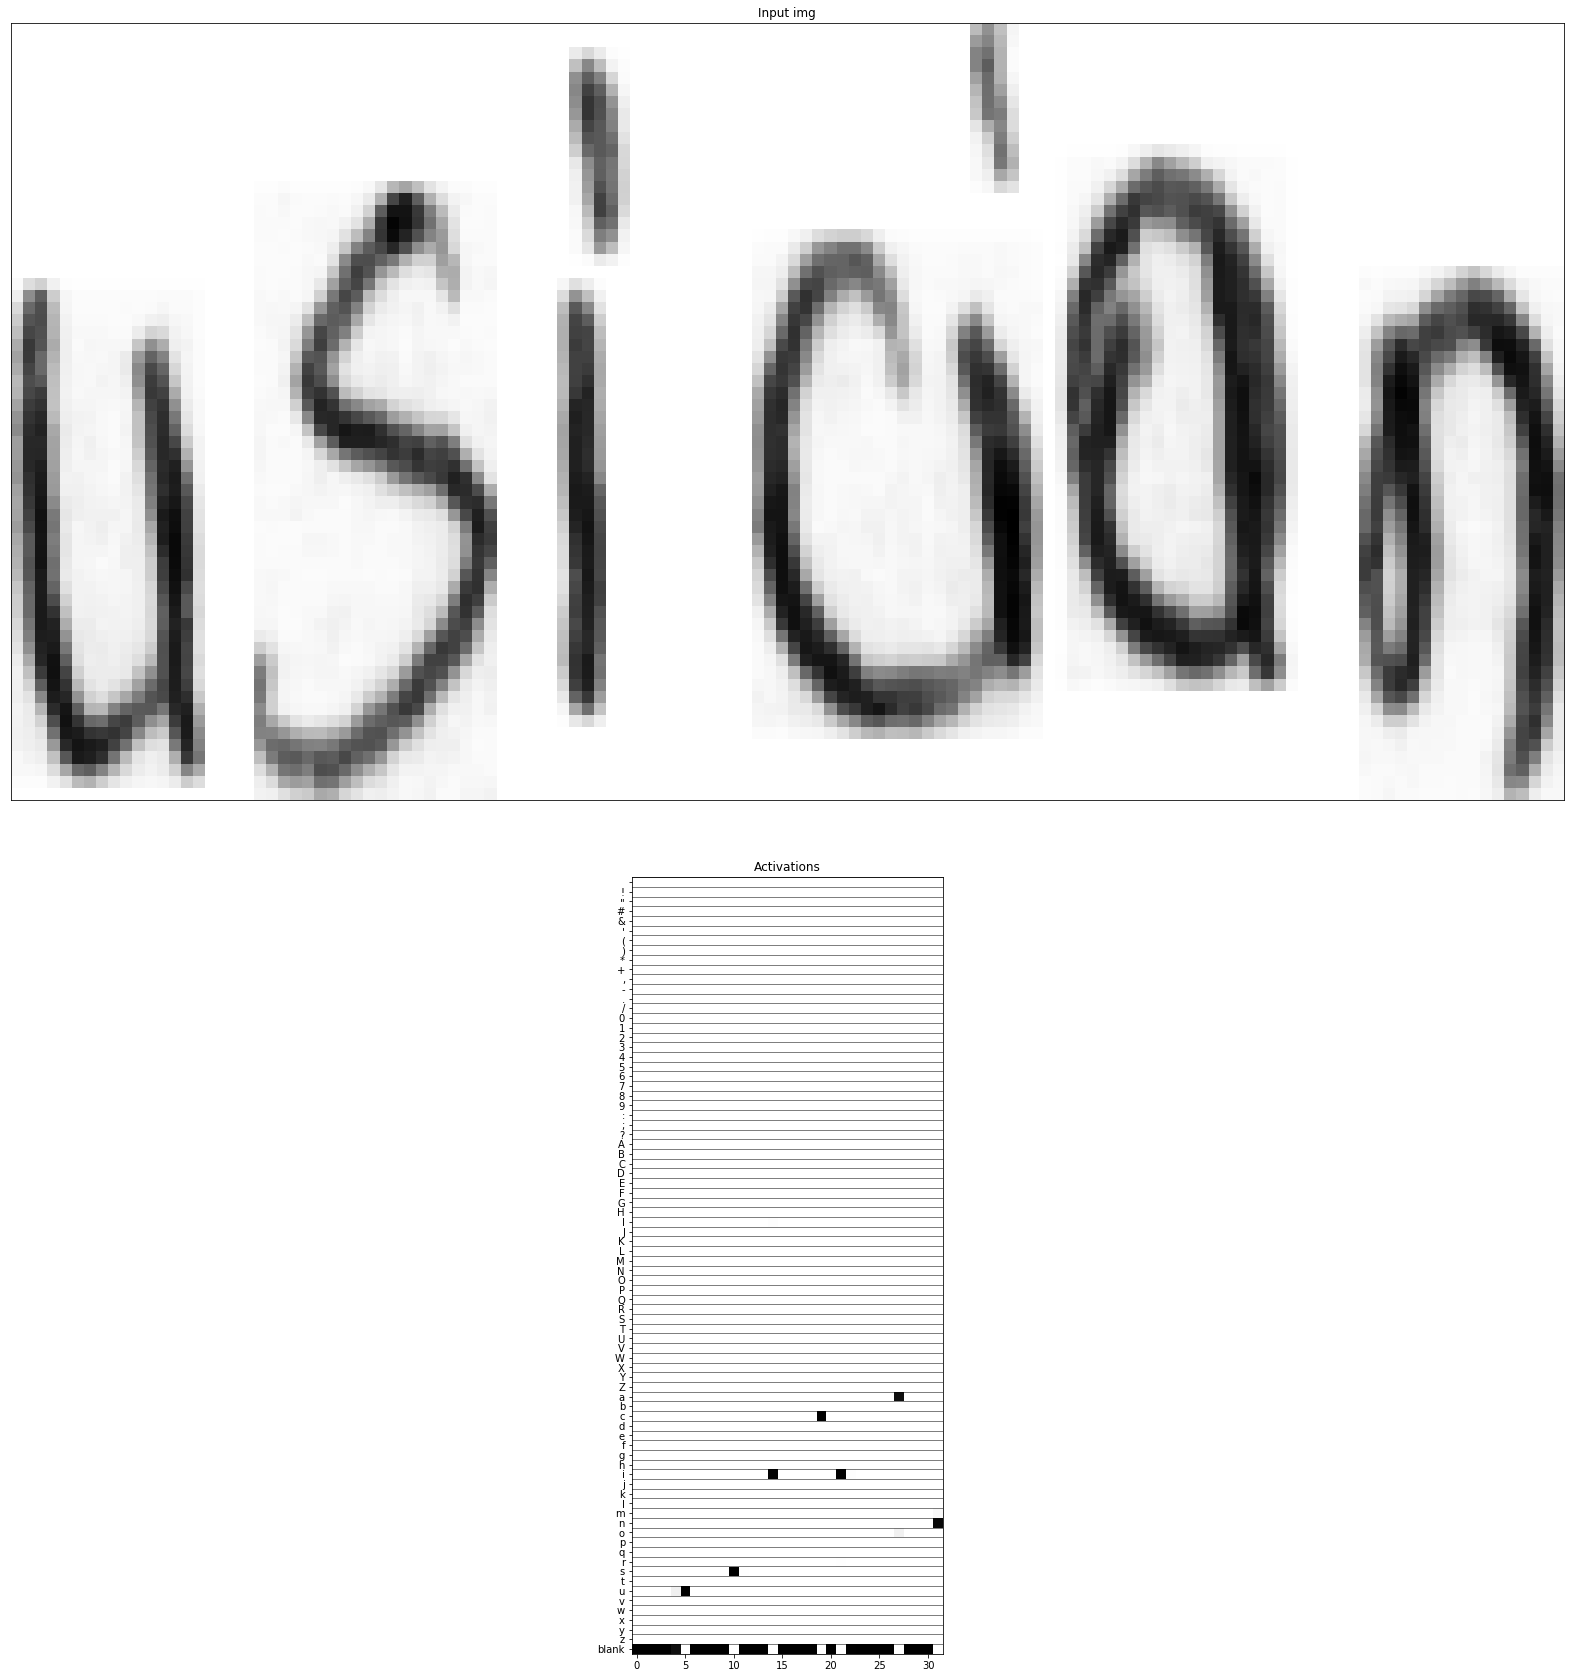

In [96]:
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

def decode_batch(out):
    ret = []
    probs = []
    for j in range(out.shape[0]):
#         print(out[j, 2:].shape)
        probs = np.max(out[j, 2:], 1)
        out_best = list(np.argmax(out[j, 2:], 1))
#         print(out_best)
        print([letters[c] for c in out_best if c < len(letters)])
#                 outstr += letters[c]
#         out_best = [k for k, g in itertools.groupby(out_best)]
#         print(out_best)
        print()
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
            else:
                outstr += '--'
        ret.append(outstr)
    print(probs)
    return ret

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

for inp_value, _ in test_tiger.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(30, 30))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break